In [140]:
import numpy
import scipy.sparse
from scipy.sparse.linalg import spsolve

import quadpy

import plotly.graph_objects as go
from plotly.subplots import make_subplots

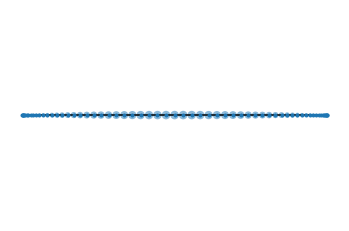

In [141]:
# some quadrature rule
scheme = quadpy.c1.gauss_patterson(5)
scheme.show()

In [142]:
def point_edge_coord(p, e0, e1):
    e = e1 - e0
    return (p - e0).dot(e) / e.dot(e)

def point_edge_distance(p, e0, e1):
    t = numpy.clip(point_edge_coord(p, e0, e1), 0, 1)
    d = p - ((e1 - e0) * t + e0)
    return d.dot(d)

def point_on_edge(p, e0, e1):
    return point_edge_distance(p, e0, e1) < 1e-8

## Meshes

In [143]:
V_coarse = numpy.array([
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0],
], dtype=float)

E_coarse = numpy.array([
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
])

m = V_coarse.shape[0]
n = 3
alphas = numpy.linspace(0, 1, n + 2)[1:-1]
V_fine = numpy.vstack(
    list(V_coarse) + 
    [(v1 - v0) * alpha + v0 for v0, v1 in V_coarse[E_coarse] for alpha in alphas]
)
# V_fine += 0.1 * numpy.random.random(V_fine.shape)

E_fine = []
for i in range(m):
    for j in range(n + 1):
        E_fine.append([
            i if j == 0 else (m - 1) + n * i + j, 
            ((i + 1) % m) if j == n else (m - 1) + n * i + j + 1])
E_fine = numpy.array(E_fine)

U_coarse = numpy.zeros(V_coarse.shape)
U_coarse[V_coarse[:, 0] > 0.999, 1] = 1
U_fine = numpy.zeros(V_fine.shape)
U_fine[V_fine[:, 0] > 0.999, 1] = 1

In [144]:
coarse_coll = False
if coarse_coll:
    V_coll, V_fem = V_coarse, V_fine
    E_coll, E_fem = E_coarse, E_fine
    U_coll, U_fem = U_coarse, U_fine
else:
    V_coll, V_fem = V_fine, V_coarse
    E_coll, E_fem = E_fine, E_coarse
    U_coll, U_fem = U_fine, U_coarse

# V_fem = V_coll
# E_fem = E_coll
# U_fem = U_coll

## Upsample-Downsample Method

In [145]:
def upsample(V, E, edge_splits):
    alphas = numpy.linspace(0, 1, edge_splits + 2)[1:-1]
    upsampled_V = [V]
    downsample_buddy = [[[i, 1]] for i in range(V.shape[0])]
    i= V.shape[0]
    for e in E:
        v0, v1 = V[e]
        for alpha in alphas:
            downsample_buddy[e[0]].append([i, 1-alpha])
            downsample_buddy[e[1]].append([i, alpha])
            upsampled_V.append((v1 - v0) * alpha + v0)
            i += 1
    return numpy.vstack(upsampled_V), downsample_buddy

In [146]:
def compute_W(V_coll, V_fem, E_fem):
    W = numpy.zeros((V_coll.shape[0], V_fem.shape[0]))

    for i, v in enumerate(V_coll):
        ds = numpy.array([point_edge_distance(v, e0, e1) for e0, e1 in V_fem[E_fem]])
        ei = ds.argmin()
        e = E_fem[ei]
        e0, e1 = V_fem[e]
        t = numpy.clip(point_edge_coord(v, e0, e1), 0, 1)
        W[i, e[0]] = 1 - t
        W[i, e[1]] = t

    print(numpy.linalg.norm(V_coll - W @ V_fem))
    return W

In [147]:
def downsample(W, downsample_buddies):
    W_downsampled = numpy.vstack([
        # W[i] + W[buddies].sum(axis=0)
        sum(weight * W[buddy] for buddy, weight in buddies)
        for buddies in downsample_buddies])
    W_downsampled /= W_downsampled.sum(axis=1)[:, None]
    return W_downsampled

In [148]:
edge_splits = 10
V_coll_upsampled, downsample_buddy = upsample(V_coll, E_coll, edge_splits)
W = compute_W(V_coll_upsampled, V_fem, E_fem)
W_new = downsample(W, downsample_buddy)

2.0770370905276122e-16


## L2 Projection

In [149]:
def hat_phi0(x):
    return 1-x
def hat_phi1(x):
    return x

In [150]:
def build_bases(V, E):
    return [{
        "n_bases": 2,
        # 2 bases
        "phi": [hat_phi0, hat_phi1],
        # local to global mapping
        "loc_2_glob": e.tolist(),
        # geometric mapping
        "gmapping": lambda x, e=e: (V[e[1]] - V[e[0]]) * x + V[e[0]],
        "grad_gmapping": lambda _: numpy.linalg.norm(V[e[1]]-V[e[0]]),
    } for e in E]

In [152]:
def compute_mass_mat(elements):
    rows, cols, vals = [], [], []
    
    # same as above but now we use phi instead of grad_phi and no division
    for el in elements:
        for i, phi_i in enumerate(el["phi"]):
            for j, phi_j in enumerate(el["phi"]):
                # ∫_{ŝ_j} ϕ̂ᵢ⋅ϕ̂ⱼ \,(s_{j, 1} - s_{j, 0})
                val = scheme.integrate(
                    lambda x: phi_i(x) * phi_j(x) * el["grad_gmapping"](x),
                    [0.0, 1.0])

                rows.append(el["loc_2_glob"][i])
                cols.append(el["loc_2_glob"][j])
                vals.append(val)

    return scipy.sparse.coo_matrix((vals, (rows, cols))).tocsc()
    

In [153]:
def find_and_eval(pt, bases, poly, E):
    assert(len(bases) == len(poly))
    
    distances = numpy.array([
        point_edge_distance(pt, e0, e1) for e0, e1 in poly[E]
    ])

    # find the closest element index
    index = distances.argmin()
    # find the coords of the closest point in the closest element
    closest_point = point_edge_coord(pt, *poly[E[index]])
    
    el = bases[index]
    return [
        (el["loc_2_glob"][j], el["phi"][j](closest_point))
        for j in range(el["n_bases"])
    ]

In [154]:
def compute_mass_mat_cross(a, b, poly_b, e_b):
    rows, cols, vals = [], [], []
    
    q_pts = (scheme.points+1)/2 # [-1, 1] -> [0, 1]
    q_w = scheme.weights/2 # sum(w) = 2 -> sum(w) = 1
    
    for el in a:
        for i in range(el["n_bases"]):
            others = {}
            
            for q in range(len(q_w)):
                t = q_pts[q]
                w = q_w[q]
                
                pt = el["gmapping"](t)
                bb = find_and_eval(pt, b, poly_b, e_b)
                
                for j in bb:
                    if j[0] in others:
                        others[j[0]] += w*j[1]*el["phi"][i](t) * el["grad_gmapping"](t)
                    else:
                        others[j[0]] = w*j[1]*el["phi"][i](t) * el["grad_gmapping"](t)
            
            for j in others:
                rows.append(el["loc_2_glob"][i])
                cols.append(j)
                vals.append(others[j])

    return scipy.sparse.coo_matrix((vals, (rows, cols))).tocsc()

In [155]:
A = V_coll[:, 0:2]
E_A = E_coll
B = V_fem[:, 0:2]
E_B = E_fem

A_bases = build_bases(A, E_A)
B_bases = build_bases(B, E_B)

M = compute_mass_mat_cross(A_bases,B_bases, B, E_B)
MM = compute_mass_mat(A_bases)

M.shape, MM.shape

((16, 4), (16, 16))

In [156]:
A = spsolve(MM, M)
A.data[numpy.abs(A.data)<1e-15] = 0
A.prune()

W_new = A
print(W_new.A)

[[1.   0.   0.   0.  ]
 [0.   1.   0.   0.  ]
 [0.   0.   1.   0.  ]
 [0.   0.   0.   1.  ]
 [0.75 0.25 0.   0.  ]
 [0.5  0.5  0.   0.  ]
 [0.25 0.75 0.   0.  ]
 [0.   0.75 0.25 0.  ]
 [0.   0.5  0.5  0.  ]
 [0.   0.25 0.75 0.  ]
 [0.   0.   0.75 0.25]
 [0.   0.   0.5  0.5 ]
 [0.   0.   0.25 0.75]
 [0.25 0.   0.   0.75]
 [0.5  0.   0.   0.5 ]
 [0.75 0.   0.   0.25]]


## Visualization

In [157]:
def MeshTrace(V, E, mode="markers+lines", name=""):
    segments_x = []
    segments_y = []
    for e in E:
        segments_x.extend(V[e, 0].tolist() + [None])
        segments_y.extend(V[e, 1].tolist() + [None])
    return go.Scatter(x=segments_x, y=segments_y, mode=mode, name=name)

In [158]:
X_coll = V_coll + W_new @ U_fem
X_fem = V_fem + U_fem

fig = make_subplots(rows=2, cols=2)

fig.add_trace(MeshTrace(V_coll, E_coll, name="V_coll"), row=1, col=1),
fig.add_trace(MeshTrace(V_fem, E_fem, name="V_fem"), row=1, col=2),
fig.add_trace(MeshTrace(X_coll, E_coll, name="Deformed V_coll"), row=2, col=1),
fig.add_trace(MeshTrace(X_fem, E_fem, name="Deformed V_fem"), row=2, col=2),

fig.update_layout(width=800, height=800, title="Displace V_fem")

In [159]:
X_coll = V_coll + U_coll
X_fem = V_fem + W_new.T @ U_coll

fig = make_subplots(rows=2, cols=2)

fig.add_trace(MeshTrace(V_coll, E_coll, name="V_coll"), row=1, col=1),
fig.add_trace(MeshTrace(V_fem, E_fem, name="V_fem"), row=1, col=2),
fig.add_trace(MeshTrace(X_coll, E_coll, name="Deformed V_coll"), row=2, col=1),
fig.add_trace(MeshTrace(X_fem, E_fem, name="Deformed V_fem"), row=2, col=2),

fig.update_layout(width=800, height=800, title="Displace V_fem")